## Supervised Learning - Finding donors for *CharityML*

## Introduction

* We employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. 

* We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal is to construct a model that accurately predicts whether an individual makes more than $50,000.

* This sort of task arises in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  

* While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. The article by Ron Kohavi is available at [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf).

----
## Exploring the Data

The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Display the first few records
display(data.head())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Data Exploration

In [2]:
data.income.value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

In [3]:
# Total number of records
n_records = data.income.count()

# Number of records where individual's income is more than $50,000
n_greater_50k = data.income[data.income=='<=50K'].count()

# Number of records where individual's income is at most $50,000
n_at_most_50k = data.income[data.income=='>50K'].count()

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/n_records)*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 34014
Individuals making at most $50,000: 11208
Percentage of individuals making more than $50,000: 75.21560302507629%


From our exploration of dataset we can classify the variables in dataset as 
* **age**: Numerical 
* **workclass**: Categorical
* **education**: Categorical
* **education-num**: Numerical 
* **marital-status**: Categorical
* **occupation**: Categorical
* **relationship**: Categorical
* **race**: Categorical
* **sex**: Categorical 
* **capital-gain**: Categorical 
* **capital-loss**: Categorical 
* **hours-per-week**: Numerical 
* **native-country**: Categorical

----
## Preparing the Data

### Transforming Skewed Continuous Features

Numerical variables which are not normally distributed, i.e. left or right skewed can adversly affect our analysis. Hence try to transform these variables to normally distributed variables using some mathematical functions.

With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


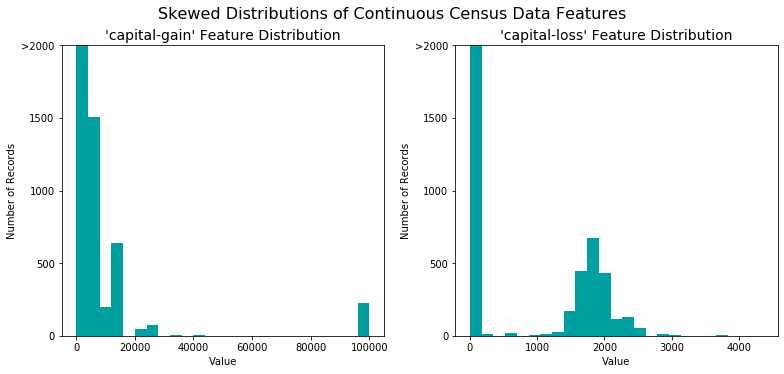

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
fig = pl.figure(figsize = (11,5));

# Skewed feature plotting
for i, feature in enumerate(['capital-gain','capital-loss']):
    ax = fig.add_subplot(1, 2, i+1)
    ax.hist(data[feature], bins = 25, color = '#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 2000))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
fig.tight_layout()
fig.show()

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


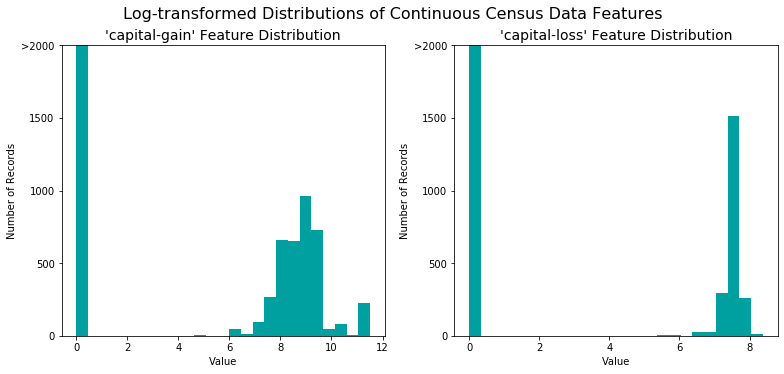

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
# Visualize skewed continuous features of original data
fig = pl.figure(figsize = (11,5));

# Skewed feature plotting
for i, feature in enumerate(['capital-gain','capital-loss']):
    ax = fig.add_subplot(1, 2, i+1)
    ax.hist(features_log_transformed[feature], bins = 25, color = '#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 2000))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

fig.suptitle("Log-transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
fig.tight_layout()
fig.show()

### Scaling Numerical Features

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Scaling ensures that each feature is treated equally when applying supervised learners.


In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. 
To convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature.

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work.

In [7]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
categorical_labels=['workclass','education_level','marital-status','occupation','relationship','race','sex','native-country']
features_final = pd.get_dummies(features_log_minmax_transform,columns=categorical_labels)

# Encode the 'income_raw' data to numerical values
z = {'<=50K': 0, '>50K': 1}
income = income_raw.map(z)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data

Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.


In [8]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data.

### Building a naive predictor which assigns everyone in same class

In [9]:

TP = np.sum(income) 
# Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data ...
# ... encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP 
# Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = (TP+TN)/(TP+TN+FP+FN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta=0.5
fscore = (1+beta**2)*precision*recall/((beta**2)*precision+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}, precision: {:.4f}, recall: {:.4f}]"
      .format(accuracy, fscore, precision, recall))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917, precision: 0.2478, recall: 1.0000]


###  Supervised Learning Models

### Creating a Training and Predicting Pipeline

In [10]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import fbeta_score
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])# = None
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_train = learner.predict(X_train[:300])
    predictions_test = learner.predict(X_test)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation

In [11]:
# Import supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# Initialize the three models
clf_A = LogisticRegression(random_state=42)
clf_B = svm.SVC(random_state=42)
clf_C = RandomForestClassifier(random_state=42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(0.1*len(y_train))
samples_1 = int(0.01*len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)


/home/prakul/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/prakul/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/prakul/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


/home/prakul/.local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/prakul/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/prakul/.local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 361 samples.
SVC trained on 3617 samples.


/home/prakul/.local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.


/home/prakul/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 36177 samples.


### Run metrics visualization for the three supervised learning models chosen

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


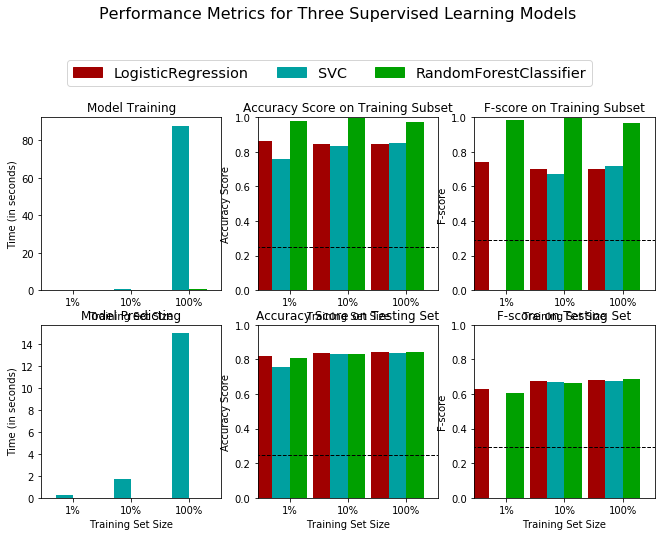

In [17]:
# Run metrics visualization for the three supervised learning models chosen
# Create figure
fig, ax = pl.subplots(2, 3, figsize = (11,7))

# Constants
bar_width = 0.3
colors = ['#A00000','#00A0A0','#00A000']

# Super loop to plot four panels of data
for k, learner in enumerate(results.keys()):
    for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
        for i in np.arange(3):

            # Creative plot code
            ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
            ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
            ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
            ax[j//3, j%3].set_xlabel("Training Set Size")
            ax[j//3, j%3].set_xlim((-0.1, 3.0))

# Add unique y-labels
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 1].set_ylabel("Accuracy Score")
ax[0, 2].set_ylabel("F-score")
ax[1, 0].set_ylabel("Time (in seconds)")
ax[1, 1].set_ylabel("Accuracy Score")
ax[1, 2].set_ylabel("F-score")

# Add titles
ax[0, 0].set_title("Model Training")
ax[0, 1].set_title("Accuracy Score on Training Subset")
ax[0, 2].set_title("F-score on Training Subset")
ax[1, 0].set_title("Model Predicting")
ax[1, 1].set_title("Accuracy Score on Testing Set")
ax[1, 2].set_title("F-score on Testing Set")

# Add horizontal lines for naive predictors
ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[0, 2].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1, 2].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')

# Set y-limits for score panels
ax[0, 1].set_ylim((0, 1))
ax[0, 2].set_ylim((0, 1))
ax[1, 1].set_ylim((0, 1))
ax[1, 2].set_ylim((0, 1))

# Create patches for the legend
patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
           loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')

# Aesthetics
pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
pl.tight_layout()
pl.show()

----
## Improving Results

In [20]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestClassifier

#Initialize the classifier
clf = RandomForestClassifier(random_state=42)


# Create the parameters list you wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators':[1,10,100,200,300],
             'criterion':['gini','entropy'],
              'max_depth':[2,4,6,8,10],
              'min_samples_split':[2,3,4],
              'min_samples_leaf':[2,4,6,8]
             }

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf_C, param_grid=parameters,scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)


/home/prakul/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/prakul/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [21]:
from sklearn.metrics import accuracy_score
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8433
F-score on testing data: 0.6848

Optimized Model
------
Final accuracy score on the testing data: 0.8545
Final F-score on the testing data: 0.7255


----
## Feature Importance

In [24]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

/home/prakul/.local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


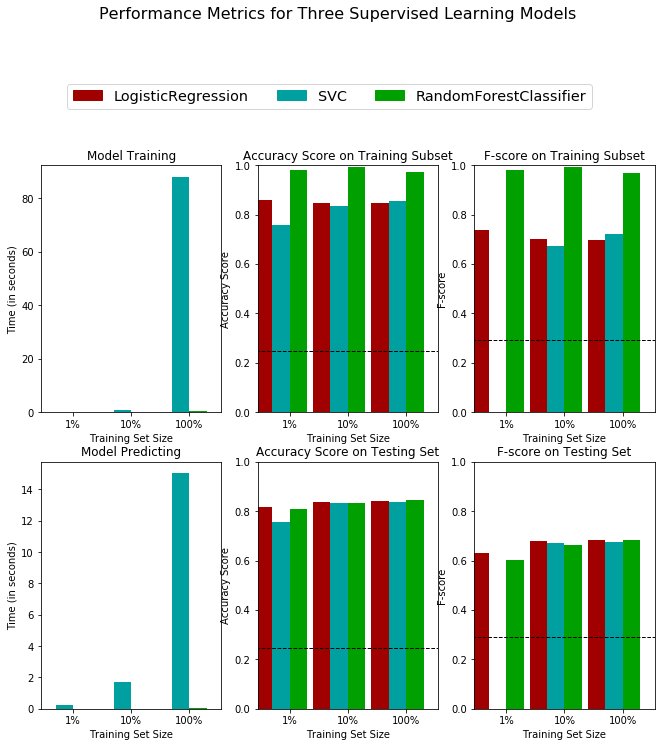

In [29]:
# Create figure
fig, ax = pl.subplots(2, 3, figsize = (11,10))

# Constants
bar_width = 0.3
colors = ['#A00000','#00A0A0','#00A000']

# Super loop to plot four panels of data
for k, learner in enumerate(results.keys()):
    for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
        for i in np.arange(3):

            # Creative plot code
            ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
            ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
            ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
            ax[j//3, j%3].set_xlabel("Training Set Size")
            ax[j//3, j%3].set_xlim((-0.1, 3.0))

# Add unique y-labels
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 1].set_ylabel("Accuracy Score")
ax[0, 2].set_ylabel("F-score")
ax[1, 0].set_ylabel("Time (in seconds)")
ax[1, 1].set_ylabel("Accuracy Score")
ax[1, 2].set_ylabel("F-score")

# Add titles
ax[0, 0].set_title("Model Training")
ax[0, 1].set_title("Accuracy Score on Training Subset")
ax[0, 2].set_title("F-score on Training Subset")
ax[1, 0].set_title("Model Predicting")
ax[1, 1].set_title("Accuracy Score on Testing Set")
ax[1, 2].set_title("F-score on Testing Set")

# Add horizontal lines for naive predictors
ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[0, 2].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1, 2].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')

# Set y-limits for score panels
ax[0, 1].set_ylim((0, 1))
ax[0, 2].set_ylim((0, 1))
ax[1, 1].set_ylim((0, 1))
ax[1, 2].set_ylim((0, 1))

# Create patches for the legend
patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
           loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')

# Aesthetics
pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
pl.tight_layout()
pl.show()

### Feature Selection

Lets trying training the model with a limited feature set of top five variables.

In [30]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8545
F-score on testing data: 0.7255

Final Model trained on reduced data
------
Accuracy on testing data: 0.8475
F-score on testing data: 0.7036


#### Generating HTML file

In [31]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 536384 bytes to finding_donors.html']